## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [32]:
import numpy as np
import cv2
import pickle
import os
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib inline

In [33]:
### Used this as reference
### https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines

In [35]:
###First I have to rename all my images and video to something easier
os.getcwd()
### Renaming the road images
IMG=('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA PICS/')
for i,imagename in enumerate(os.listdir(IMG)):
    os.rename('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA PICS/'+imagename,
             'C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA PICS/'+'Image '+str(i)+'.jpg')

### Renaming the calibration images
CALIBRATION=('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA CALIBRATION/')
for i, calibrationimages_name in enumerate(os.listdir(CALIBRATION)):
    os.rename('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA CALIBRATION/'+calibrationimages_name,
             'C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA CALIBRATION/'+'Calibration Images '+str(i)+'.jpg')
    
### Renaming the test video
VIDEO=('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA VIDEO/')    
for i, videoname in enumerate(os.listdir(VIDEO)):
    os.rename('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA VIDEO/'+videoname,
             'C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA VIDEO/'+'Custom Video'+str(i)+'.mp4')

In [36]:
### With that out of the way now lets do everyhting as we did earlier, with some changes 
### like this i will try to use sobel threshold as well
## alongwith sobel absoulute and sobel direction as well

In [38]:
###CAMERA CALIBRATION

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA CALIBRATION/*.jpg')
plt.figure(figsize=(30,30))
# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        plt.subplot(5,4,i)  ###displaying the chess board patterns
    
        plt.imshow(img)
        plt.axis('on')



## And so on and so forth...

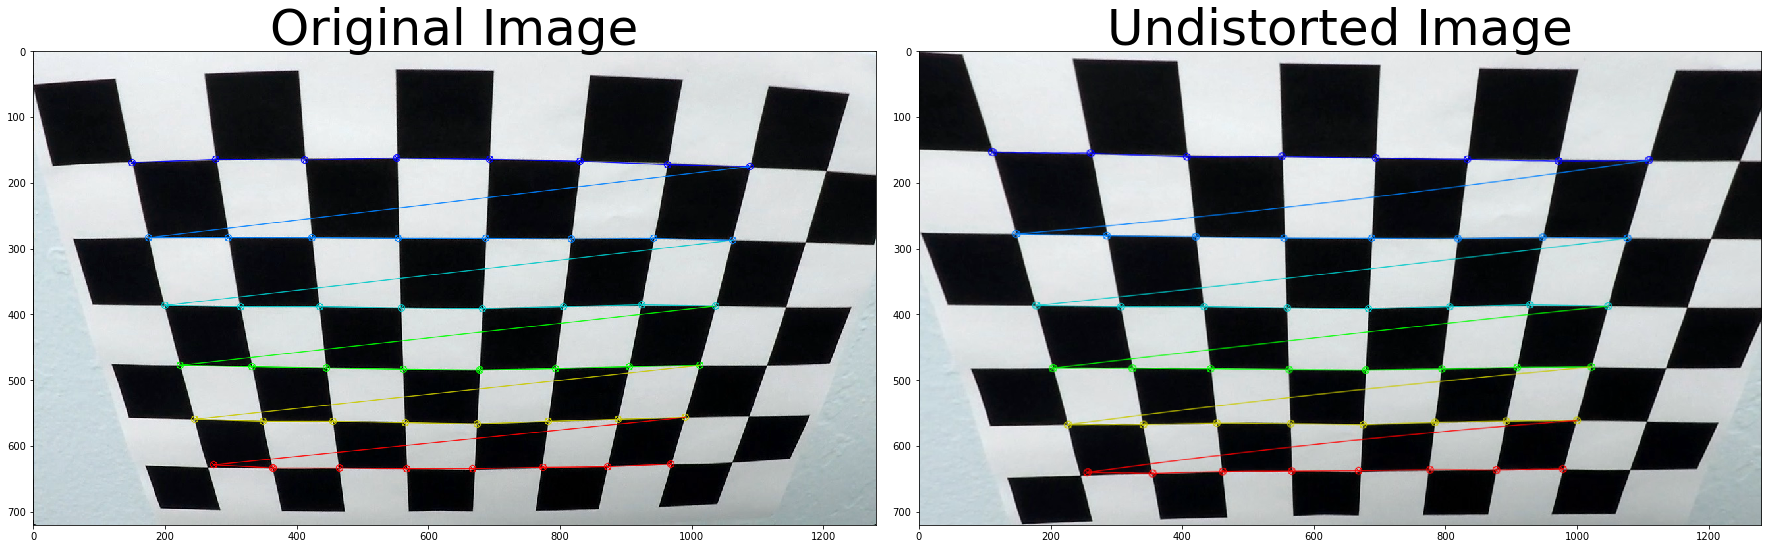

In [4]:
img=cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
# Use cv2.calibrateCamera() and cv2.undistort()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

undist = dst = cv2.undistort(img, mtx, dist, None, mtx)  

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###Displaying the last image

I used the code from lesson itself.I choose the image which I though to be most distorted, just to see the results clearly and we can see that the function is doing a good job.

(720, 1280, 3)


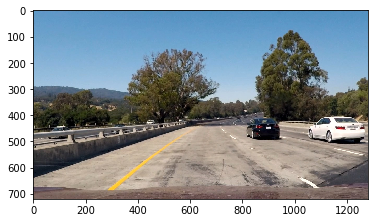

In [5]:
# Choose an image from which to build and demonstrate each step of the pipeline

Img = cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test1.jpg')
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
print(Img.shape)
plt.imshow(Img)


In [6]:
### Now to undistort it
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

fig,axs=plt.subplots(12,2,figsize=(30,30))
fig.tight_layout()
plt.subplots_adjust(left=0., right=0.5, top=0.9, bottom=0.)
axs[0,0].set_title('Original Image', fontsize=0)
axs[0,1].set_title('Undistorted Image', fontsize=30)

i=0
for I in glob.glob('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/MY CAMERA/*.jpeg'):
    Img=cv2.imread(I)
    Img_undistort = undistort(cv2.imread(I))
    ### Now to visualize it like we did earlier
    axs[i,0].imshow(Img) 
    axs[i,1].imshow(Img_undistort)
    i+=1

SyntaxError: invalid syntax (<ipython-input-6-0e26f468194a>, line 9)

The distortion is quite subtle but can easily be seen on the hood of the car and on the left hand side mountain peak and also on the white car.

720 1280


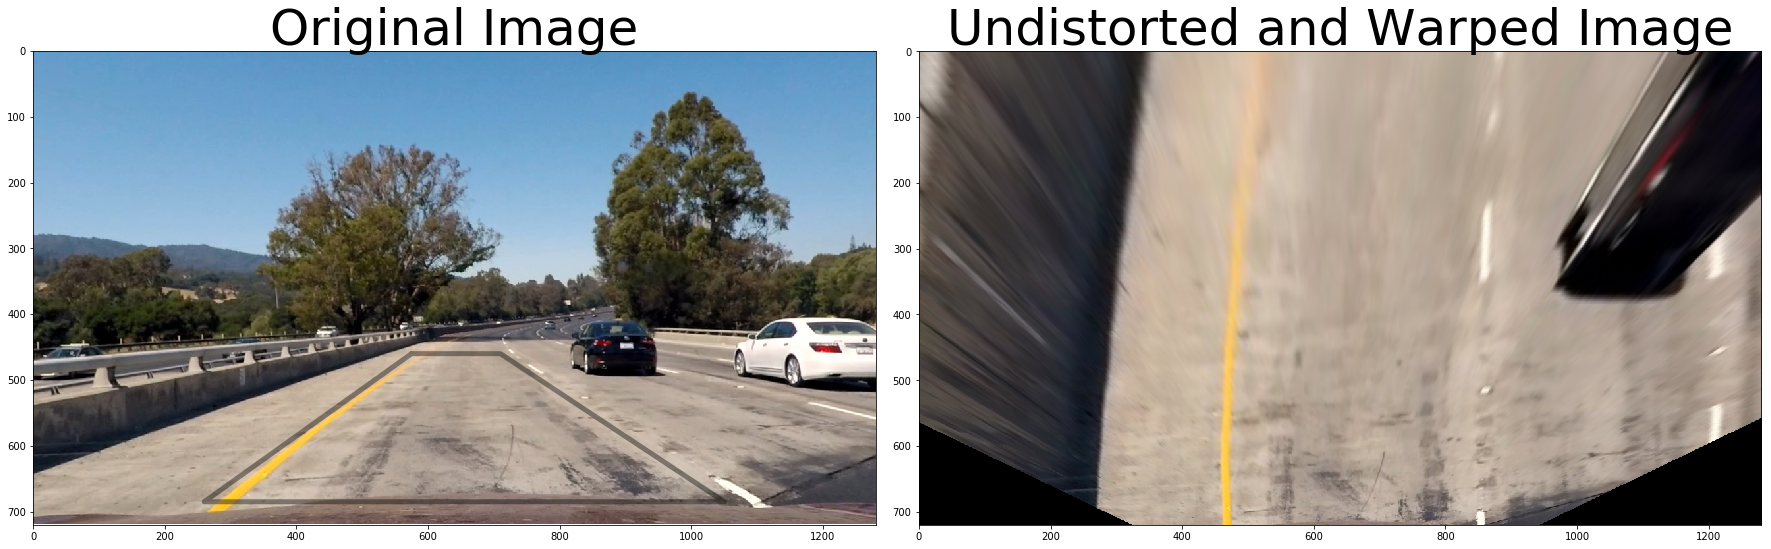

In [6]:
### NOW LETS DO THE PERSPECTIVE TRANFORMATION. This is also from the lesson itself.

h,w = Img_undistort.shape[:2]
print (h,w)

src = np.float32([(575,460),
                  (710,460), 
                  (260,685), 
                  (1050,685)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

def corners_warp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    

Top_down, M, Minv = corners_warp(Img_undistort, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

###TO SEE THE SELECTED REGION
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#000000', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.imshow(Img_undistort)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(Top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Here is the bird's eye view of the concerned region.

In [7]:
### NOW LETS VISUALIZE THIS IMAGE IN DIFFERENT COLOUR SPACES AND THEN CHOOSE THE BEST ONE

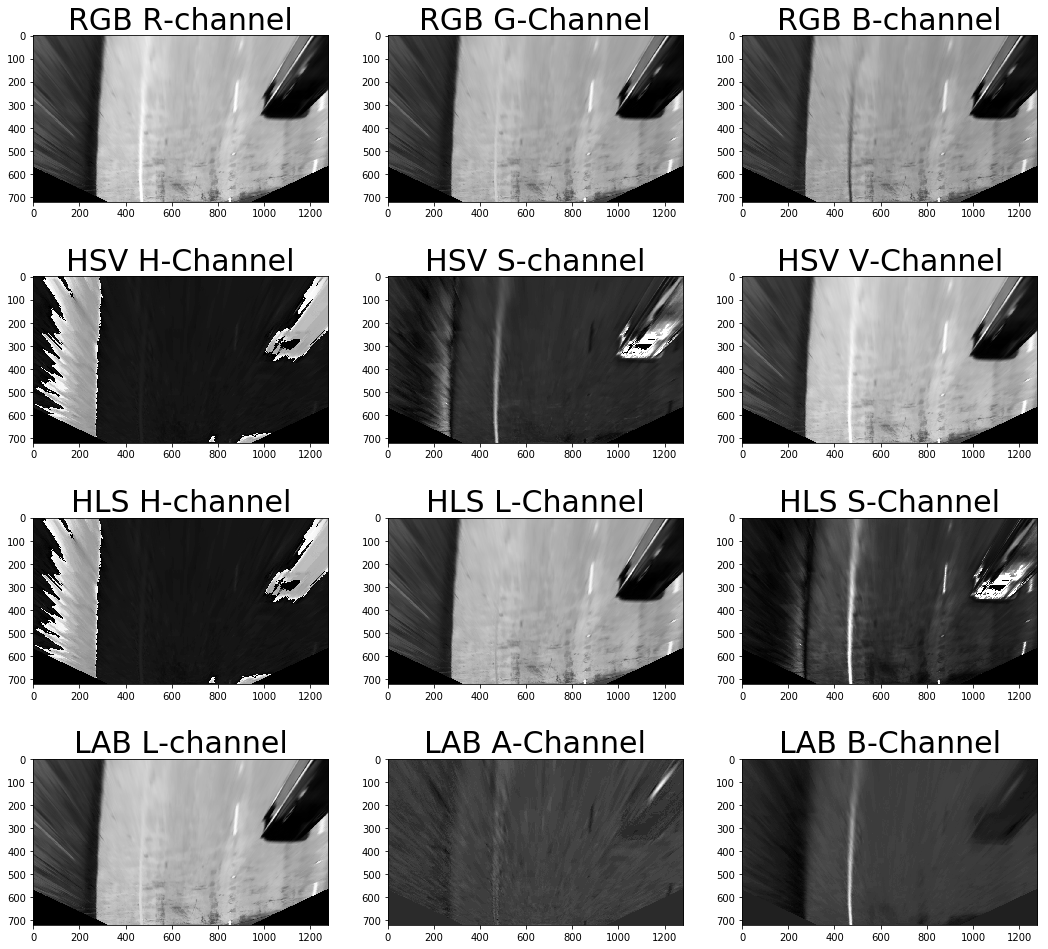

In [8]:
# Visualize multiple color space channels
def channels(top_down):
    top_down_R = top_down[:,:,0]
    top_down_G = top_down[:,:,1]
    top_down_B = top_down[:,:,2]
    top_down_HSV = cv2.cvtColor(top_down, cv2.COLOR_RGB2HSV)
    top_down_H = top_down_HSV[:,:,0]
    top_down_S = top_down_HSV[:,:,1]
    top_down_V = top_down_HSV[:,:,2]
    top_down_HLS = cv2.cvtColor(top_down, cv2.COLOR_RGB2HLS)
    top_down_H1 = top_down_HLS[:,:,0]
    top_down_L = top_down_HLS[:,:,1]
    top_down_S1 = top_down_HLS[:,:,2]
    top_down_LAB= cv2.cvtColor(top_down, cv2.COLOR_RGB2LAB)
    top_down_L1 = top_down_LAB[:,:,0]
    top_down_A = top_down_LAB[:,:,1]
    top_down_B1 = top_down_LAB[:,:,2]
    fig, axs = plt.subplots(4,3, figsize=(18, 17))
    axs = axs.ravel()
    axs[0].imshow(top_down_R, cmap='gray')
    axs[0].set_title('RGB R-channel', fontsize=30)
    axs[1].imshow(top_down_G, cmap='gray')
    axs[1].set_title('RGB G-Channel', fontsize=30)
    axs[2].imshow(top_down_B, cmap='gray')
    axs[2].set_title('RGB B-channel', fontsize=30)
    axs[3].imshow(top_down_H, cmap='gray')
    axs[3].set_title('HSV H-Channel', fontsize=30)
    axs[4].imshow(top_down_S, cmap='gray')
    axs[4].set_title('HSV S-channel', fontsize=30)
    axs[5].imshow(top_down_V, cmap='gray')
    axs[5].set_title('HSV V-Channel', fontsize=30)
    axs[6].imshow(top_down_H1, cmap='gray')
    axs[6].set_title('HLS H-channel', fontsize=30)
    axs[7].imshow(top_down_L, cmap='gray')
    axs[7].set_title('HLS L-Channel', fontsize=30)
    axs[8].imshow(top_down_S1, cmap='gray')
    axs[8].set_title('HLS S-Channel', fontsize=30)
    axs[9].imshow(top_down_L1, cmap='gray')
    axs[9].set_title('LAB L-channel', fontsize=30)
    axs[10].imshow(top_down_A, cmap='gray')
    axs[10].set_title('LAB A-Channel', fontsize=30)
    axs[11].imshow(top_down_B1, cmap='gray')
    axs[11].set_title('LAB B-Channel', fontsize=30)
    
channels(Top_down)

Hmmmmmmmmmmmm........ Many channels are giving promising images. Let's try another image just to make sure. Though the winner seems clear.
RGB R channel is doing pretty good and so is the HSV V channel.
RGB B channel is also doing pretty good but it is changing the line colours thus disturbing the contrast.
Someone also suggested to use the LAB colour space, and they were quite right, it very clearly detects the left lane and removes the right lane, so I can combine it with the other channels to get a good output.

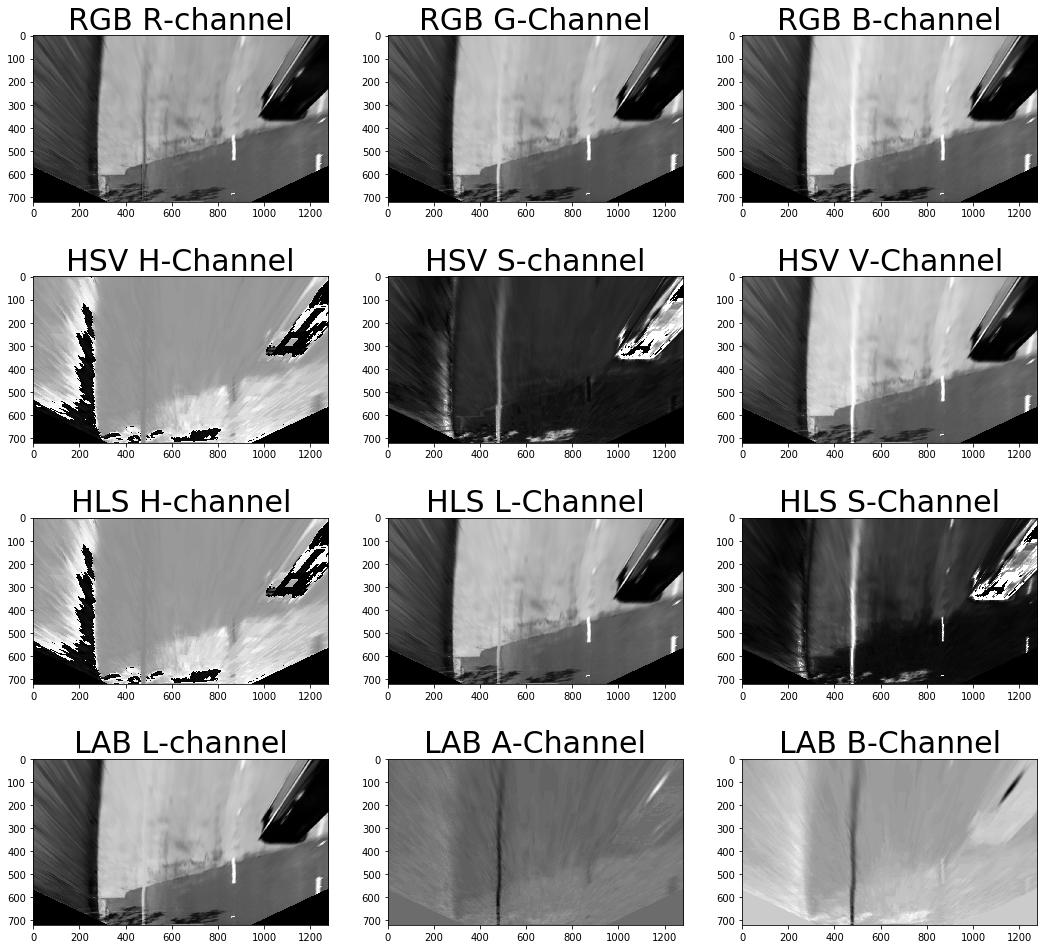

In [9]:
img=cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')

IMAGE=undistort(img)
IMAGE,m1,minv1=corners_warp(IMAGE,src,dst)
channels(IMAGE)

The HSV V channel or RGB B channel can be used but they lose their contrast in the shady regions of the road. 
The HLS L channel also looks good for the fact the it might of a similar colour, but it maintains that colour throughout.
I will be combining the LAB A channel as well with other image probably with the HLS S channel.

In [3]:
def hls_lthresh(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls[:,:,1]= hls[:,:,1]*(255/np.max(hls[:,:,1]))         ###Normalization
    binary_output = np.zeros_like(hls[:,:,1])
    binary_output[(hls[:,:,1]> thresh[0]) & (hls[:,:,1] <= thresh[1])] = 1
    #plt.imshow(binary_output)
    return binary_output

def lab_Bthresh(img , thresh=(190,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    binary_output = np.zeros_like(lab[:,:,2])
    if (np.max(lab[:,:,2])>175):
        lab[:,:,2]=lab[:,:,2]*(255/np.max(lab[:,:,2]))       ###Normalization
    binary_output[(lab[:,:,2] > thresh[0]) & (lab[:,:,2] <= thresh[1])] = 1
    return binary_output

def hsv_Sthresh(img , thresh=(10,107)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary_output= np.zeros_like(hsv[:,:,1])
    hsv[:,:,1]= hsv[:,:,1]*(255/np.max(hsv[:,:,1]))          ###Normaliztion
    binary_output[(hsv[:,:,1]> thresh[0]) & (hsv[:,:,1]<= thresh[1])]=1


<function __main__.updateHLS>

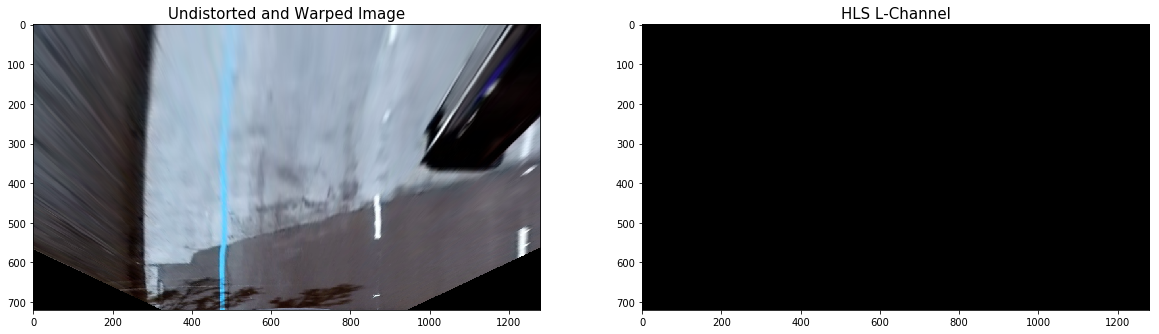

In [11]:
def updateHLS(min_thresh, max_thresh):
    Img_lThresh = hls_lthresh(IMAGE, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(IMAGE,cmap='gray')
    ax1.set_title('Undistorted and Warped Image', fontsize=15)
    ax2.imshow(Img_lThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=15)

interact(updateHLS,min_thresh=(0,255),max_thresh=(0,255))
###Also used the sliders just to make it a little more interactive and I found out about it recently. so we can directly select the thresholds.

<function __main__.updateLAB>

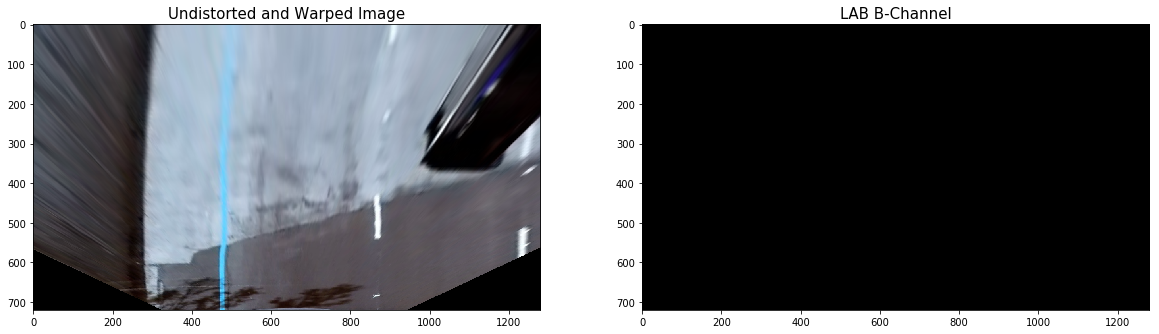

In [12]:
def updateLAB(min_thresh, max_thresh):
    Img_BThresh = lab_Bthresh(IMAGE, (min_thresh, max_thresh))
    # Visualize lab b-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(IMAGE,cmap='gray')
    ax1.set_title('Undistorted and Warped Image', fontsize=15)
    ax2.imshow(Img_BThresh, cmap='gray')
    ax2.set_title('LAB B-Channel', fontsize=15)

interact(updateLAB,min_thresh=(0,255),max_thresh=(0,255))

In [13]:
###That seems perfect. But we need to test on all the images just to be sure. I am actually not able to visualize it for 
###some reason

In [4]:
def pipeline(img):
    UNDIST=undistort(img)
    WARPED,m,minv=corners_warp(UNDIST,src,dst)
    L_THRESH=hls_lthresh(WARPED)
    B_THRESH=lab_Bthresh(WARPED)
    #S_THRESH=hsv_Sthresh(WARPED) 
    ### I actually tried using a third channel as well but the results didnot vary so removed it
    ### Also there was some issue visualizing it 
    
    ###Combine the thresh holds for better images
    combined=np.zeros_like(B_THRESH)
    #combined[(L_THRESH==1)|(B_THRESH==1)|(S_THRESH==1)]=1
    combined[(L_THRESH==1)|(B_THRESH==1)]=1
    return combined,minv

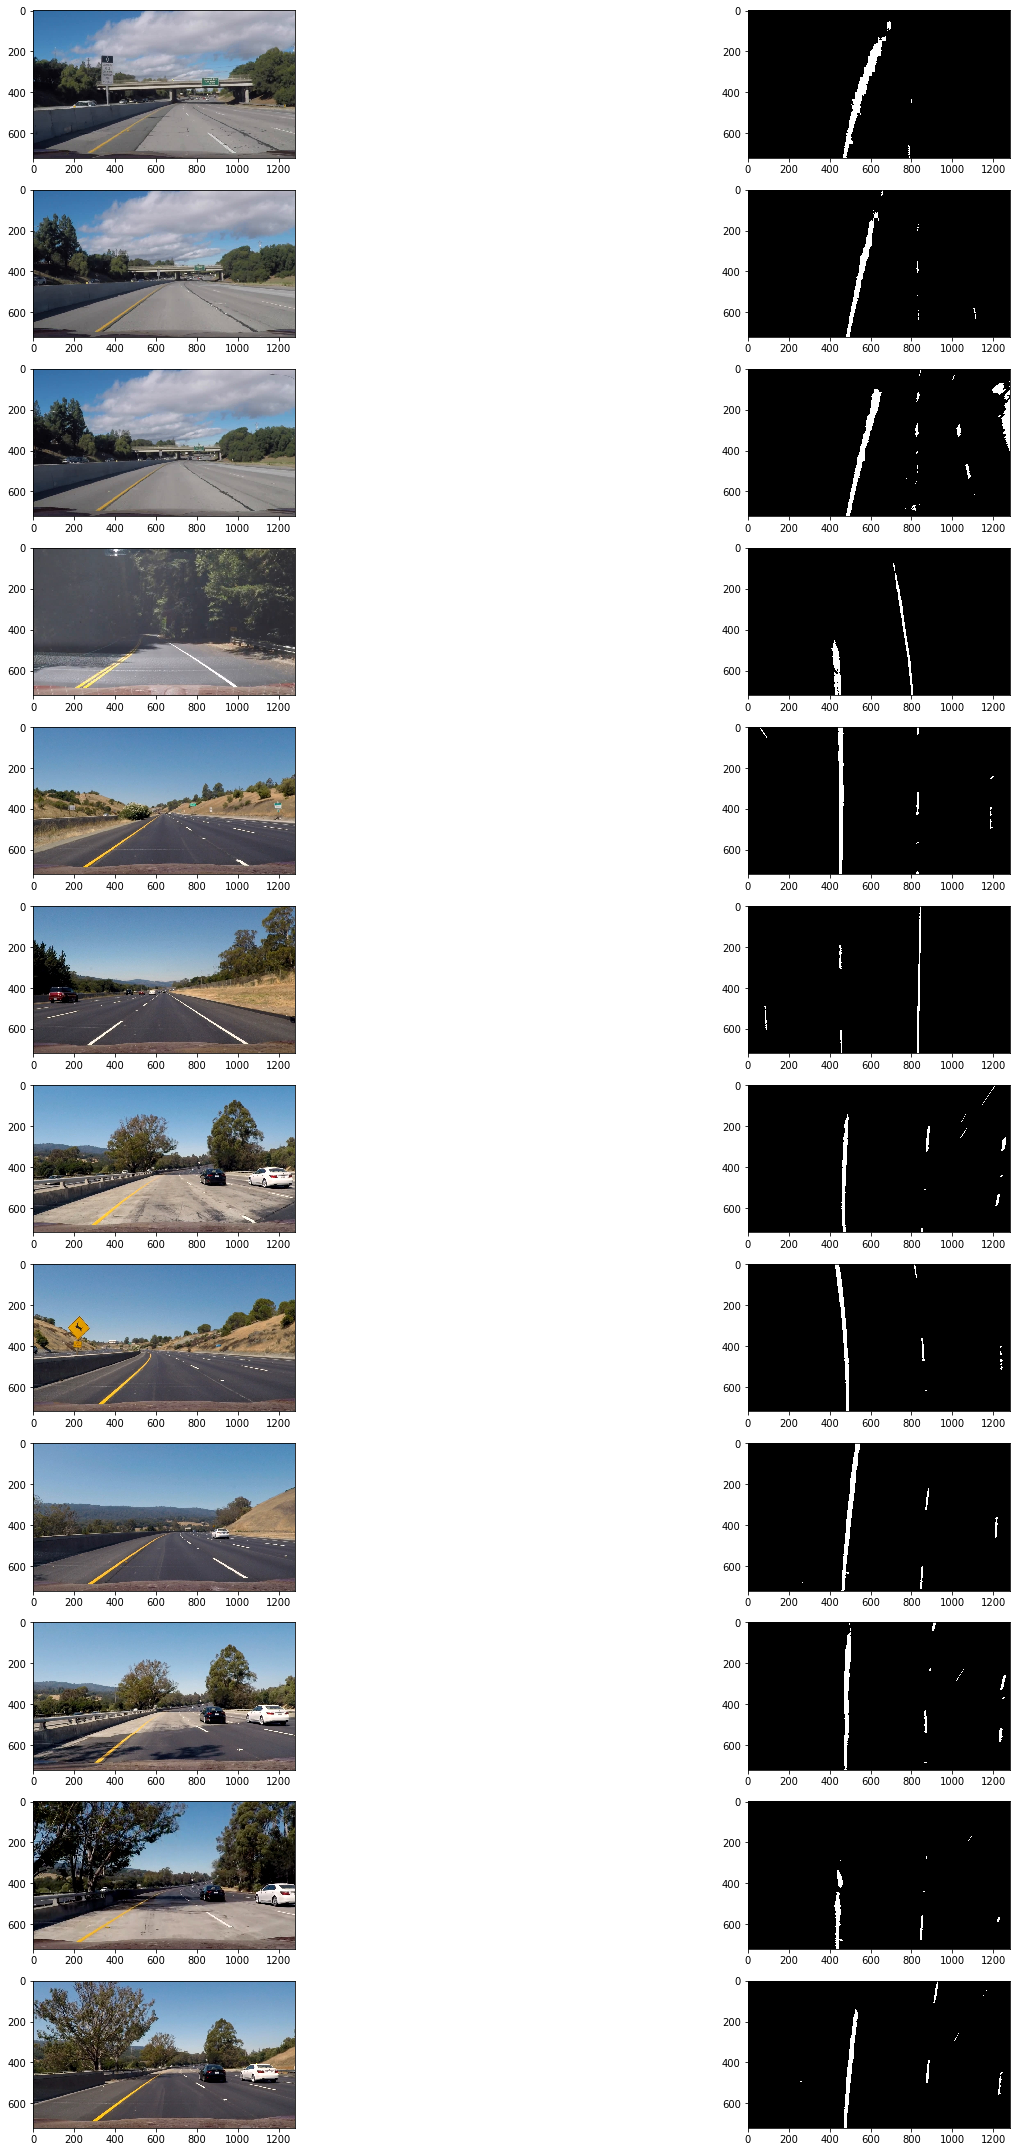

In [15]:
# Make a list of example images
images = glob.glob('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(20, 30))
#fig.subplots_adjust(hspace = .2, wspace=.001)
fig.tight_layout()
axs = axs.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin1, Minv = pipeline(img)
    axs[i].imshow(img)
    i += 1
    axs[i].imshow(img_bin1, cmap='gray')
    i += 1

### Sliding Window Method

In [5]:
def sliding_window(img):
    histogram=np.sum(img[img.shape[0]//2:,:],axis=0)
    
    ###Find the mid points and the lane lines to draw the histogram
    mid=np.int(histogram.shape[0]//2)
    other_point=mid//2
    
    ### The reason why I used this is becuase of the fact that in one of the images test1
    ### The detected lane lines were waaaaaaaaaaaay off so I restricted them in a region 
    ### The natural instinct was to use a quater point as used here and voila it worked first try.....
    ### This was actually suggested by a friend on slack
    
    leftbase_x=np.argmax(histogram[other_point:mid])+other_point
    rightbase_x=np.argmax(histogram[mid:mid+other_point])+mid
    
    ###Defining the number of windows
    nwindows=10
    
    ###Height of windows
    window_height=np.int(img.shape[0]//nwindows)
    
    ###Finding the non zero pixel values
    non_zero=img.nonzero()
    non_zerox=np.array(non_zero[1])
    non_zeroy=np.array(non_zero[0])
    
    ###Positions to be updated
    leftbase_x_current=leftbase_x
    rightbase_x_current=rightbase_x
    
    ###Width of windows
    width=80
    
    ###Minimum pixels to be found to recentre 
    r_min=40
    
    ###Left and Right lane indices
    left_lane=[]
    right_lane=[]
    rectangle_data=[]
    
    for windows in range(nwindows):
        win_low_y=img.shape[0]-(windows+1)*window_height
        win_high_y=img.shape[0]-windows*window_height
        win_low_xleft=leftbase_x_current-width
        win_high_xleft=leftbase_x_current+width
        win_low_xright=rightbase_x_current-width
        win_high_xright=rightbase_x_current+width
        
        ###Draw windows on images
        rectangle_data.append((win_low_y,win_high_y,win_low_xleft,win_high_xleft,win_low_xright,win_high_xright))
        
        ###The pixel values must lie in the the windows
        left_inds=((non_zeroy>=win_low_y)&(non_zeroy<win_high_y)&
                   (non_zerox>=win_low_xleft)&(non_zerox<win_high_xleft)).nonzero()[0]
        right_inds=((non_zeroy>=win_low_y)&(non_zeroy<win_high_y)&
                   (non_zerox>=win_low_xright)&(non_zerox<win_high_xright)).nonzero()[0]
        
        ###Appending the required indices
        left_lane.append(left_inds)
        right_lane.append(right_inds)
        
        if len(left_inds)>r_min:
            leftbase_x_current=np.int(np.mean(non_zerox[left_inds]))
        if len(right_inds)>r_min:
            rightbase_x_current=np.int(np.mean(non_zerox[right_inds]))
            
    ###Concatenate the array of indices
    left_lane=np.concatenate(left_lane)
    right_lane=np.concatenate(right_lane)
        
    ###Extracting the x and y co-ordinates for the left and right lane lines
    leftx = non_zerox[left_lane]
    lefty = non_zeroy[left_lane] 
    rightx = non_zerox[right_lane]
    righty = non_zeroy[right_lane]
    
    ###Fitting a polynomial to the lane line
    left_fit=np.polyfit(lefty,leftx,2)
    right_fit=np.polyfit(righty,rightx,2)
    
    visualization_data=(rectangle_data,histogram)
    
    
#     print (left_fit)
#     print (right_fit)
    
    return left_fit,right_fit,left_lane,right_lane,visualization_data

(720, 0)

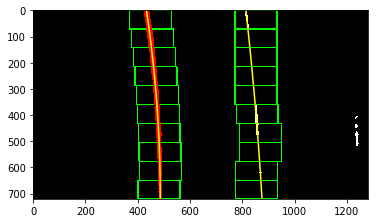

In [13]:
def fit_polynomial(Img):
#Img=cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test2.jpg')
    Image=cv2.cvtColor(Img,cv2.COLOR_BGR2RGB)
    Image_warped,minv=pipeline(Image)
    left_fit,right_fit,left_inds,right_inds,Visualization_data=sliding_window(Image_warped)

    Rectangle=Visualization_data[0]
    histogram=Visualization_data[1]

        ###Finding the polynomial
    plot=np.linspace(0,Img.shape[0]-1,Img.shape[0])     ###Returns evenly spaced numbers
    left_fitx=left_fit[0]*plot**2+left_fit[1]*plot+left_fit[2]
    right_fitx=right_fit[0]*plot**2+right_fit[1]*plot+right_fit[2]

    OutImg = (np.dstack((Image_warped, Image_warped, Image_warped))*255)
    ###Make rectangle on the image
    for rect in Rectangle:
        cv2.rectangle(OutImg,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
        cv2.rectangle(OutImg,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 

        ###Draw the fitted polynomials on the image
    nonzero=Image_warped.nonzero()
    non_zerox=np.array(nonzero[1])
    non_zeroy=np.array(nonzero[0])

    OutImg[non_zeroy[left_inds],non_zerox[left_inds]]=[255,0,0]           ###Setting the colors
    OutImg[non_zeroy[right_inds],non_zerox[right_inds]]=[255,255,255]

    return right_fitx, right_fit, left_fitx, left_fit, plot, histogram, OutImg
    
Img=cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test2.jpg')

right_fitx, right_fit, left_fitx, left_fit, plot, histogram, OutImg= fit_polynomial(Img)

### ========================================NOTE===========================================================
### PLEASE READ THIS: THIS IS KINDA IMPORTANT BECAUSE THIS IS NOT THE MOST READABLE CODE THAT I HAVE WRITTEN
### right_fitx and left_fitx are the values used for plotting the lane lines
### where as the right_fit and left_fit are the values of the three constants
### and sorry for this mess ;-;

plt.imshow(OutImg)
plt.plot(left_fitx, plot,  color='yellow')
plt.plot(right_fitx, plot,  color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(0, 1280)

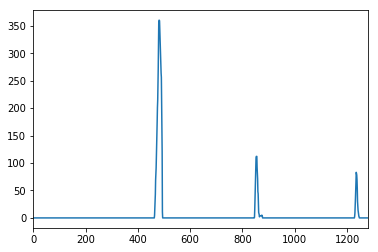

In [18]:
plt.plot(histogram)
plt.xlim(0,1280)
###Good enough

### Previous fit method

(720, 0)

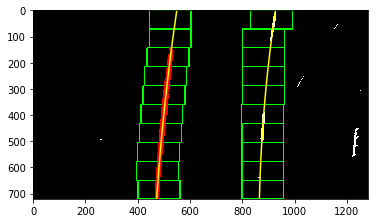

In [19]:
### Polyfit fit using previous window fit method
### As we know this method takes the assumption that the the detected lane lines donot change much from one frame to another
### I assume that the test 6,4,5,1 are almost in chronological order
### So firstly fitting the polynomial for the test6 image
### I have taken the code for this method from the lesson itself

Img1=cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test6.jpg')

right_fitx, right_fit, left_fitx, left_fit, plot, histogram, OutImg=fit_polynomial(Img1)

plt.imshow(OutImg)
plt.plot(left_fitx, plot,  color='yellow')
plt.plot(right_fitx, plot,  color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [14]:
###We can assume that test 6,4,5,1 are in chronological order
def previous_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720, 0)

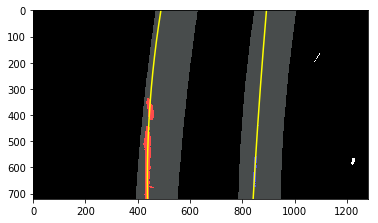

In [21]:
# visualize the result on example image
Img2 = cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test5.jpg')
Img2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2RGB)
Img2_warped, Minv = pipeline(Img2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = previous_fit(Img2_warped, left_fit, right_fit)

# Generate x and y values for plotting
plot = np.linspace(0, Img2_warped.shape[0]-1, Img2_warped.shape[0] )
left_fitx = left_fit[0]*plot**2 + left_fit[1]*plot + left_fit[2]
right_fitx = right_fit[0]*plot**2 + right_fit[1]*plot + right_fit[2]
left_fitx2 = left_fit2[0]*plot**2 + left_fit2[1]*plot + left_fit2[2]
right_fitx2 = right_fit2[0]*plot**2 + right_fit2[1]*plot + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((Img2_warped, Img2_warped, Img2_warped))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = Img2_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, plot]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, plot])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, plot]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, plot])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (240 ,255, 255))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (240 ,255, 255))       ###I know this is a strange colour
                                                                           ###but it readily shows the locations because of the 
                                                                           ###contrast
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, plot, color='yellow')
plt.plot(right_fitx2, plot, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
### Finally its correct after much troubleshooting just because my code is quite messy

In [22]:
### As can be easily understood this method is only good till the time the road is curving smoothly 
### As soon as the road starts to make sharp turn (or the road contractor went full Formula 1 and made a nice chicane)
### This technique is pretty much useless, but on the positive side this can save a lot of processing time and the load on the
### system can be significantly reduced

### Measuring the radius of the lanes and also the distance from the lane centres

In [15]:
### Method to determine radius of curvature and distance from lane center 
### based on binary image, polynomial fit, and L and R lane pixel indices
### I will be honest this required quite a lot of help

def calc_curv_rad_and_center_dist(warped_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
   
    h = warped_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = warped_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [19]:
Img=cv2.imread('C:/Users/SIDAUS/CarND-Advanced-Lane-Lines-master/test_images/test6.jpg')
Img=cv2.cvtColor(Img,cv2.COLOR_BGR2RGB)
Img_warped,minv=pipeline(Img)
left_fit,right_fit,left_inds,right_inds,Visualization_data=sliding_window(Img_warped)

### Programming can be very strange, I realized it in this very code block
### Don't ask how or why but nonetheless strange

rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(Img_warped, left_fit, right_fit, left_inds, right_inds)

print('Radius of curvature for left lane is:', rad_l, 'm, and for right lane is:', rad_r, 'm')
print('Distance from lane center is:', d_center, 'm')

Radius of curvature for left lane is: 850.07200815 m, and for right lane is: 550.466680283 m
Distance from lane center is: -0.28311611554 m


In [16]:
### This part also had me seeking for help a couple of times

def draw_lane(original_img, warped_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = warped_img.shape
    plot = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*plot**2 + l_fit[1]*plot + l_fit[2]
    right_fitx = r_fit[0]*plot**2 + r_fit[1]*plot + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, plot]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plot])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255 ))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


YESSSSSSSS!!!!!!!!!!!


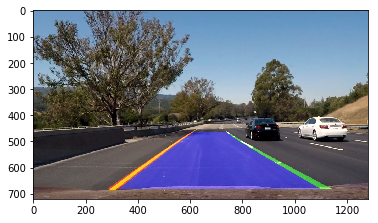

In [20]:
Output_img = draw_lane(Img, Img_warped, left_fit, right_fit, minv)
plt.imshow(Output_img)
print ('YESSSSSSSS!!!!!!!!!!!')

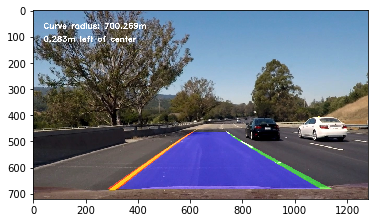

In [21]:
### Now lets write the radius of curvature of the lane lines on the images itself
def write_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: {:.3f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return new_img

Output_img2 = write_data(Output_img, (rad_l+rad_r)/2, d_center)
plt.imshow(Output_img2)

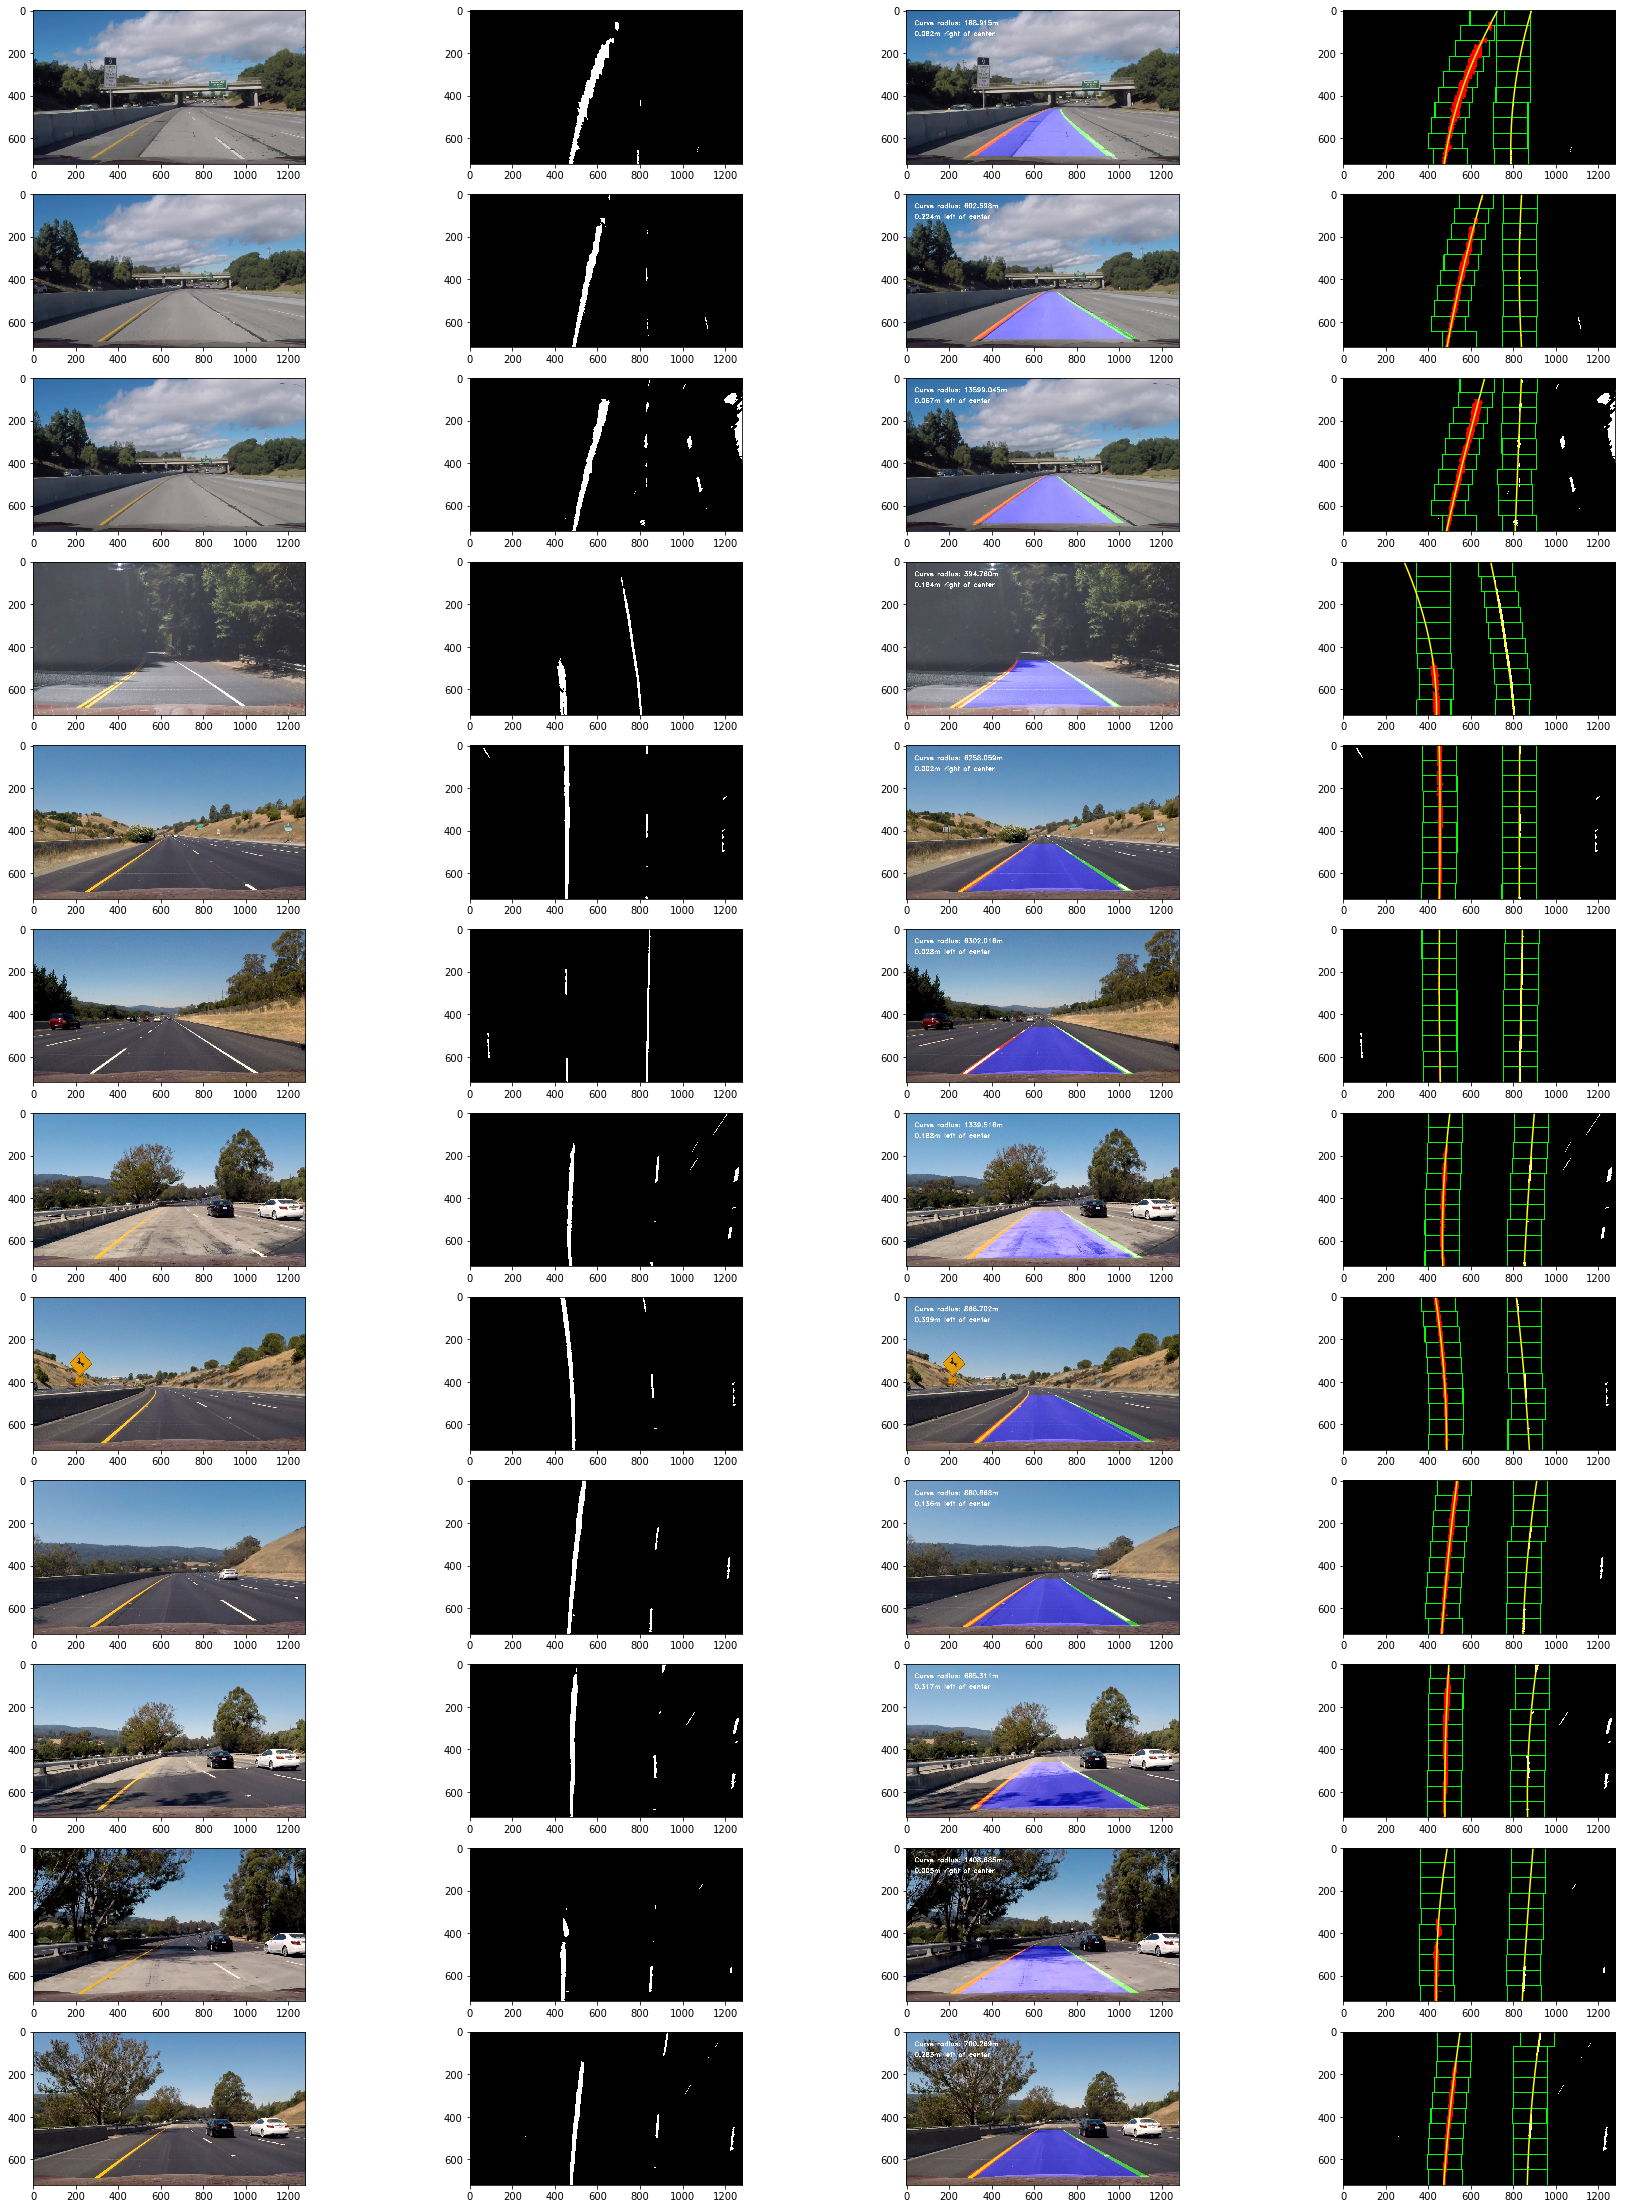

In [22]:
### Lets visualize everything and then we can work on the image processsing pipiline

TEST_IMAGES=glob.glob('../CarND-Advanced-Lane-Lines-master/test_images/*')

fig,axs=plt.subplots(len(TEST_IMAGES),4, figsize=(30,40))
axs.ravel()
i=0
for test in TEST_IMAGES:
    TEST=cv2.imread(test)
    
    RIGHTFIT_X, RIGHT_FIT, LEFTFIT_X, LEFT_X, PLOT, HISTOGRAM, OUT_IMAGE=fit_polynomial(TEST) 
    ###GENERATING AND FITTING THE POLYNOMIAL
    
    TEST=cv2.cvtColor(TEST,cv2.COLOR_BGR2RGB)
    TEST_WARPED,MINV=pipeline(TEST) ###GENERATING THE BINARY IMAGE
    
    LEFT_FIT,RIGHT_FIT,LEFT_INDS,RIGHT_INDS,VISUALIZATION_DATA=sliding_window(TEST_WARPED) ### For some reason whenever I tried
    ### to get the left and right indexes for calculating the lane curvatures it always gave an error for out of bounds
    ### so I had to use improvise a little and do it this way, this hinders the readablity a little bit but not much
    
    RAD_L, RAD_R, D_CENTRE = calc_curv_rad_and_center_dist(TEST_WARPED, LEFT_FIT, RIGHT_FIT, LEFT_INDS, RIGHT_INDS)
    ### Calculating the lane curvature
    
    OUTPUT_IMG=draw_lane(TEST, TEST_WARPED, LEFT_FIT, RIGHT_FIT, MINV)
    ### Drawing the lane lines back onto the original image
    
    OUTPUT_IMG=write_data(OUTPUT_IMG, (RAD_L+RAD_R)/2, D_CENTRE)
    ### Writing the data onto the image
    
    axs[i,0].imshow(TEST)
    axs[i,1].imshow(TEST_WARPED,cmap='gray')
    axs[i,2].imshow(OUTPUT_IMG)
    axs[i,3].imshow(OUT_IMAGE)
    axs[i,3].plot(LEFTFIT_X, PLOT,  color='yellow')
    axs[i,3].plot(RIGHTFIT_X, PLOT,  color='yellow')

    i+=1

In [23]:
### NICE

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
                
### I took this from the lesson


### Video Processing

In [25]:
def process_image(img):
    new_img = np.copy(img)
    img_warped, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use the previous fit method, otherwise use sliding window method
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window(img_warped)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = previous_fit(img_warped, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_warped, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_warped, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = write_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    ###multi_window_output = False
    
    multi_window_output = True
    
    if multi_window_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output 
        diag_img[0:720,0:1280,:] = cv2.resize(img_out,(1280,720))
        
        # binary overhead view (1st on top from right)
        img_warped = np.dstack((img_warped*255, img_warped*255, img_warped*255))
        resized_img_warped = cv2.resize(img_warped,(240,240))
        diag_img[0:240,1040:1280, :] = resized_img_warped
        
        # binary view with fitted lines (2nd on top from right)
        img_warped_fit = np.copy(img_warped)
        for i, fit in enumerate(l_line.current_fit):
            img_warped_fit = plot_fit_onto_img(img_warped_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_warped_fit = plot_fit_onto_img(img_warped_fit, fit, (0,20*i+100,20*i+100))
        img_warped_fit = plot_fit_onto_img(img_warped_fit, l_line.best_fit, (255,255,0))
        img_warped_fit = plot_fit_onto_img(img_warped_fit, r_line.best_fit, (255,255,0))
        diag_img[0:240,760:1000,:] = cv2.resize(img_warped_fit,(240,240))

        img_out = diag_img
        
    return img_out


In [32]:
l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:43<00:00,  3.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 47s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [26]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=12)
    return new_img


In [27]:
l_line = Line()
r_line = Line()
video_output2 = 'project_video_output2.mp4'
video_input2 = VideoFileClip('project_video.mp4')#.subclip(0,3)
processed_video2 = video_input2.fl_image(process_image)
%time processed_video2.write_videofile(video_output2, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:38<00:00,  3.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

Wall time: 5min 40s
